In [1]:
import os, sys
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('text', usetex=True)

import time, datetime
import itertools
from joblib import Parallel, delayed
import pickle

In [2]:
data_name = 'otc'

network_df = pd.read_csv('../rev2data/%s/%s_network.csv' %(data_name, data_name), header=None, names=['src', 'dest', 'rating', 'timestamp'], parse_dates=[3], infer_datetime_format=True)

user_list = ['u' + str(u) for u in network_df['src'].tolist()]

gt_df = pd.read_csv('../rev2data/%s/%s_gt.csv' %(data_name, data_name), header=None, names=['id', 'label'])
gt = dict([('u'+str(x[0]), x[1]) for x in zip(gt_df['id'], gt_df['label'])])

In [3]:
alg_list = ['rev2', 'bad', 'bn', 'trust']

alg_res = {alg_name: pickle.load(open('../%sres/%s.pkl' %(alg_name, data_name), 'rb')) for alg_name in alg_list}

## Computation
+ average precision grid
+ evading grid

In [4]:
def compute_metrics(alg_name, k, n, ind):
    ulist = alg_res[alg_name][(k, n, ind)]['ulist']
    yscore = alg_res[alg_name][(k, n, ind)]['yscore']
    ytrue = alg_res[alg_name][(k, n, ind)]['ytrue']
    ap = sklearn.metrics.average_precision_score(y_score=yscore, y_true=ytrue)
    auc = sklearn.metrics.roc_auc_score(y_score=yscore, y_true=ytrue)
    evade_list = [yscore[i] for i in range(len(ulist)) if ulist[i] not in user_list]
    er = 0
    if len(evade_list) > 0:
        er = sum([1 for s in evade_list if s > 0]) / len(evade_list)
    return ap, auc, er

pkl_path = '../res/%s.pkl' %data_name

if os.path.exists(pkl_path):
    with open(pkl_path, 'rb') as f: metrics_dict = pickle.load(f)
    print('load from %s' %pkl_path)
else:
    print('compute from scratch')
    metrics_dict = {alg_name: Parallel(n_jobs=-1, verbose=3)(delayed(compute_metrics)(alg_name, k, n, ind) for k, n, ind in itertools.product(range(11), range(11), range(20))) for alg_name in alg_list}
    with open(pkl_path, 'wb') as f: pickle.dump(metrics_dict, f)
    print('save to %s' %pkl_path)

compute from scratch


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2000 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2420 out of 2420 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Do

save to ../res/otc.pkl


[Parallel(n_jobs=-1)]: Done 2420 out of 2420 | elapsed:  5.5min finished


In [5]:
ap_dict = {alg_name: np.zeros((11, 11, 20)) for alg_name in alg_list}
auc_dict = {alg_name: np.zeros((11, 11, 20)) for alg_name in alg_list}
er_dict = {alg_name: np.zeros((11, 11, 20)) for alg_name in alg_list}

for alg_name in alg_list:
    print(alg_name)
    results_dict = dict(zip(itertools.product(range(11), range(11), range(20)), metrics_dict[alg_name]))
    for k, n, ind in itertools.product(range(11), range(11), range(20)):
        ap_dict[alg_name][k, n, ind] = results_dict[(k, n, ind)][0]
        auc_dict[alg_name][k, n, ind] = results_dict[(k, n, ind)][1]
        er_dict[alg_name][k, n, ind] = results_dict[(k, n, ind)][2]

rev2
bad
bn
trust


## Vary n

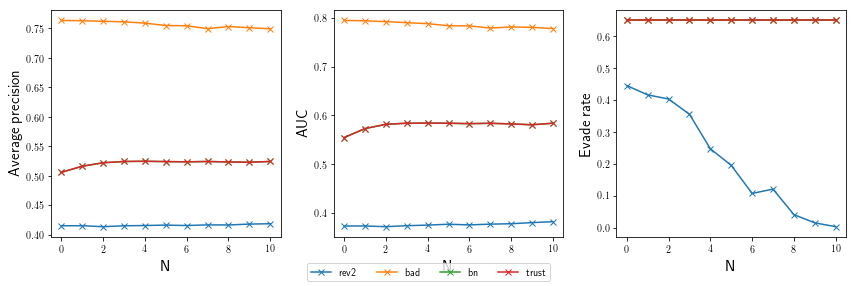

In [6]:
nfig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(0, 2))
    ax.plot(x, y, marker='x')
ax.set_ylabel('Average precision', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[1]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(auc_dict[alg_name], axis=(0, 2))
    ax.plot(x, y, marker='x')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[2]
x = np.arange(11)
lines = []
for alg_name in alg_list:
    y = np.mean(er_dict[alg_name], axis=(0, 2))
    lines += [ax.plot(x, y, marker='x')[0]]
ax.set_ylabel('Evade rate', fontsize=15)
ax.set_xlabel('N', fontsize=15)

nfig.tight_layout()
nfig.legend(lines, alg_list, loc='lower center', ncol=len(alg_list))

## Vary N given k

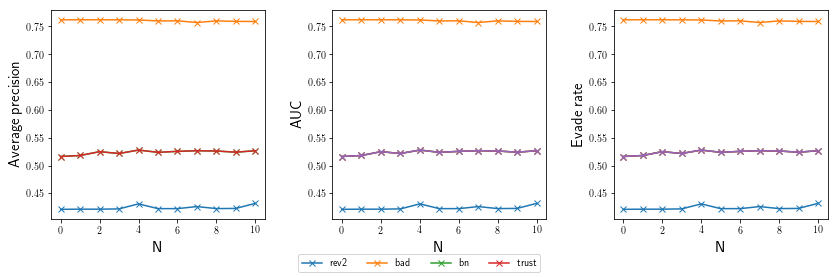

In [14]:
knfig, axes = plt.subplots(1, 3, figsize=(12, 4))

k = 2
ax = axes[0]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(2))[k, :]
    ax.plot(x, y, marker='x')
ax.set_ylabel('Average precision', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[1]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(2))[k, :]
    ax.plot(x, y, marker='x')
ax.plot(x, y, marker='x')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('N', fontsize=15)

lines = []
ax = axes[2]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(2))[k, :]
    lines += [ax.plot(x, y, marker='x')[0]]
ax.plot(x, y, marker='x')
ax.set_ylabel('Evade rate', fontsize=15)
ax.set_xlabel('N', fontsize=15)

knfig.tight_layout(pad=2)
knfig.legend(lines, alg_list, loc='lower center', ncol=len(alg_list))

## Vary k

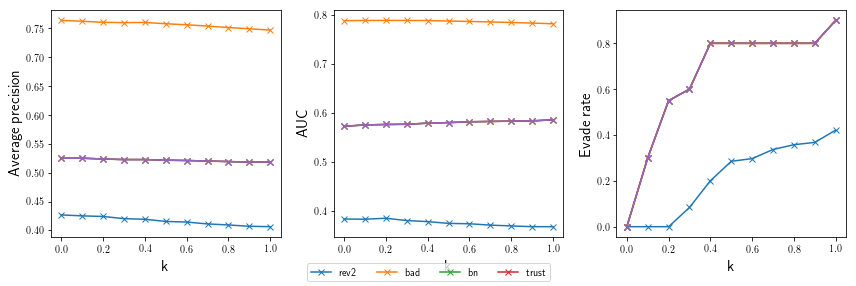

In [8]:
kfig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
x = np.arange(11)/10
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(1, 2))
    ax.plot(x, y, marker='x')
ax.plot(x, y, marker='x')
ax.set_ylabel('Average precision', fontsize=15)
ax.set_xlabel('k', fontsize=15)

ax = axes[1]
x = np.arange(11)/10
for alg_name in alg_list:
    y = np.mean(auc_dict[alg_name], axis=(1, 2))
    ax.plot(x, y, marker='x')
ax.plot(x, y, marker='x')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('k', fontsize=15)

ax = axes[2]
x = np.arange(11)/10
lines = []
for alg_name in alg_list:
    y = np.mean(er_dict[alg_name], axis=(1, 2))
    lines += [ax.plot(x, y, marker='x')[0]]
ax.plot(x, y, marker='x')
ax.set_ylabel('Evade rate', fontsize=15)
ax.set_xlabel('k', fontsize=15)

kfig.tight_layout()
kfig.tight_layout()
kfig.legend(lines, alg_list, loc='lower center', ncol=len(alg_list))

In [13]:
nfig.savefig('../rev2fig/%s-n.pdf' %data_name)
kfig.savefig('../rev2fig/%s-k.pdf' %data_name)
knfig.savefig('../rev2fig/%s-kn.pdf' %data_name)